In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import matplotlib.image as mpimg 
# !pip install scikit-build
# !pip install imgaug
# from imgaug import augmenters as iaa
import pandas as pd 
import glob 

c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git


In [3]:
os.chdir('Mask_RCNN')

In [4]:
# !pip install -r requirements.txt

In [7]:
# !python3 -m ensurepip
# !python setup.py -q install

/usr/bin/python3: No module named ensurepip
Traceback (most recent call last):
  File "setup.py", line 7, in <module>
    import pip
ImportError: No module named pip


In [6]:
# Import Mask RCNN
#!pip install -r requirements.txt
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [7]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = mpimg.imread('../sample/'+image_fp) 
        image = ds
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [8]:
ORIG_SIZE = 1024

In [9]:
anns = pd.DataFrame(columns=['image','x','y','width','height'])
anns

Empty DataFrame
Columns: [image, x, y, width, height]
Index: []

In [24]:
anndict = {}
for file in os.listdir('../sample2/'):
    if file.endswith('.json'):
        with open('../sample2/'+file[:-5]+'.json') as f:
            data = json.load(f)
            pts = data['shapes'][0]['points']
            x = int(pts[0][0])
            y = int(pts[0][1])
            width = int(pts[1][0]-pts[0][0])
            height = int(pts[1][1]-pts[0][1])
            anndict[data['imagePath']] = [x,y,width,height]
            anns = anns.append({'image':data['imagePath'], 'x':x, 'y':y, 'width':width, 'height':height},ignore_index=True)

anns

image         x         y     width    height
0    00006683_000.png  156.8125  105.9375  714.0625  662.5000
1    00006683_003.png  161.5000   40.3125  739.0625  754.6875
2    00006683_006.png  203.6875  132.5000  717.1875  582.8125
3    00006686_000.png  131.8125  124.6875  782.8125  737.5000
4    00006683_000.png  156.8125  105.9375  714.0625  662.5000
..                ...       ...       ...       ...       ...
153  00006741_000.png  158.0000  113.0000  776.0000  656.0000
154  00006741_003.png  199.0000  182.0000  617.0000  559.0000
155  00006741_006.png   80.0000  151.0000  651.0000  660.0000
156  00006741_009.png  170.0000   99.0000  782.0000  635.0000
157  00006741_015.png  206.0000  140.0000  662.0000  654.0000

[158 rows x 5 columns]

In [32]:
files = os.listdir('../sample2/')
imageList = []
for file in files:
        if file.endswith('.png'):
            imageList.append(file)

In [33]:
image_fps = imageList
image_annotations = anndict

In [20]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

KeyError: '00006687_002.png'

In [34]:
random.choice(imageList)

'00006719_000.png'

(1024, 1024)
161 900 40 794


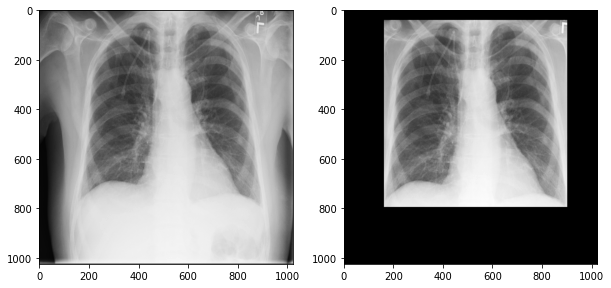

In [53]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_fp = random.choice(imageList)
image = mpimg.imread('../sample2/'+image_fp) 

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
bb = image_annotations[image_fp]
print(bb[0],bb[0]+bb[2],bb[1],bb[1]+bb[3])
for i in range(bb[0],bb[0]+bb[2]):
    for j in range(bb[1],bb[1]+bb[3]):
        masked [j,i] = image[j,i]
plt.imshow(masked, cmap='gray')


In [31]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [17]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='./')

In [18]:
dataset_val = DetectorDataset(image_fps, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [19]:
# # Image augmentation 
# augmentation = iaa.SomeOf((0, 1), [
#     iaa.Fliplr(0.5),
#     iaa.Affine(
#         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#         rotate=(-25, 25),
#         shear=(-8, 8)
#     ),
#     iaa.Multiply((0.9, 1.1))
# ])

In [20]:
NUM_EPOCHS = 1

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all')
#


Starting at epoch 0. LR=0.001

Checkpoint Path: ./pneumonia20201031T0527/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [148, 130, 746, 718], 'path': '00006687_002.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 4}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-f2efa67b52da>", line 42, in load_mask
    if a['Target'] == 1:
TypeError: 'int' object is not subscriptableERROR:root:Error processing image {'orig_height': 1024, 'annotations': [148, 130, 746, 718], 'path': '00006687_002.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 4}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(imag

TypeError: 'int' object is not subscriptable

ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [200, 127, 718, 572], 'path': '00006683_006.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 2}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-f2efa67b52da>", line 42, in load_mask
    if a['Target'] == 1:
TypeError: 'int' object is not subscriptable
ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [125, 118, 781, 734], 'path': '00006686_000.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 3}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_

Epoch 1/1


ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [139, 87, 774, 868], 'path': '00006691_001.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 6}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-f2efa67b52da>", line 42, in load_mask
    if a['Target'] == 1:
TypeError: 'int' object is not subscriptableERROR:root:Error processing image {'orig_height': 1024, 'annotations': [144, 109, 726, 641], 'path': '00006683_000.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 0}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image

TypeError: 'int' object is not subscriptableERROR:root:Error processing image {'orig_height': 1024, 'annotations': [125, 118, 781, 734], 'path': '00006686_000.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 3}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-7-f2efa67b52da>", line 42, in load_mask
    if a['Target'] == 1:
TypeError: 'int' object is not subscriptable

ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [148, 130, 746, 718], 'path': '00006687_002.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 4}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_g

TypeError: 'int' object is not subscriptableTraceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "/host/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)

  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [139, 87, 774, 868], 'path': '00006691_001.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 6}
Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/host/Mask_RCNN/mrcnn/m

TypeError: 'int' object is not subscriptable

In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))